In [55]:
import sys, os

path = "P:/Dokumente/3 Uni/SoSe21/Data_Compression/DataCompressionNew/DataCompression/exp/full_run/checkpoint_11/rl_agent.zip"

sys.path.append("P:/Dokumente/3 Uni/SoSe21/Data_Compression/DataCompressionNew")
sys.path.append(os.getcwd())
from DataCompression.src.buffer import Decoder_Buffer

from stable_baselines3 import PPO
import gym 

policy_kwargs = dict(
    features_extractor_kwargs=dict(features_dim=128))
env = gym.make("BreakoutNoFrameskip-v4")
t = PPO("CnnPolicy",env, policy_kwargs=policy_kwargs)
t.load(path);

In [85]:
import time
import torch
from tqdm import tqdm
import numpy as np
def fill_buffer(samples=100, randomly=True, use_tqdm=True):
    """Fills the buffer randomly

    Args:
        steps (int): Number of steps to take
        use_tqdm (bool): Add progress bar if True.
    """
    print(f"Filling buffer with {samples} samples")
    buffer = Decoder_Buffer([210, 160, 3], 128, 100, flatten=True)
    time.sleep(1) # to avoid printstream clashing with progressbar
    observation = env.reset()
    r = tqdm(range(samples)) if use_tqdm else range(samples)

    env_step = 0
    for i in r:
        while True:
            action = t.predict(observation)
            observation, reward, done, info = env.step(action)
            latent = torch.zeros(128)# t.policy.features_extractor(observation).detach() # make sure to detach the latents to not propagate back through rl agent in decoder training
            env_step += 1

            if env_step > 800 and env_step % 50 == 0: # min 500 steps in then every 50th
                buffer_observation = torch.from_numpy(observation).float()
                buffer.add(buffer_observation, latent)
                break
            if done:
                observation = env.reset()
                env_step = 0
                continue

    env.close()
    return buffer

In [87]:
test_buffer = fill_buffer(1000)

Filling buffer with 10 samples
Created a buffer for images of shape torch.Size([100, 100800]) and latents torch.Size([100, 128])


100%|██████████| 10/10 [02:17<00:00, 13.73s/it]


In [58]:
from matplotlib import pyplot as plt
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

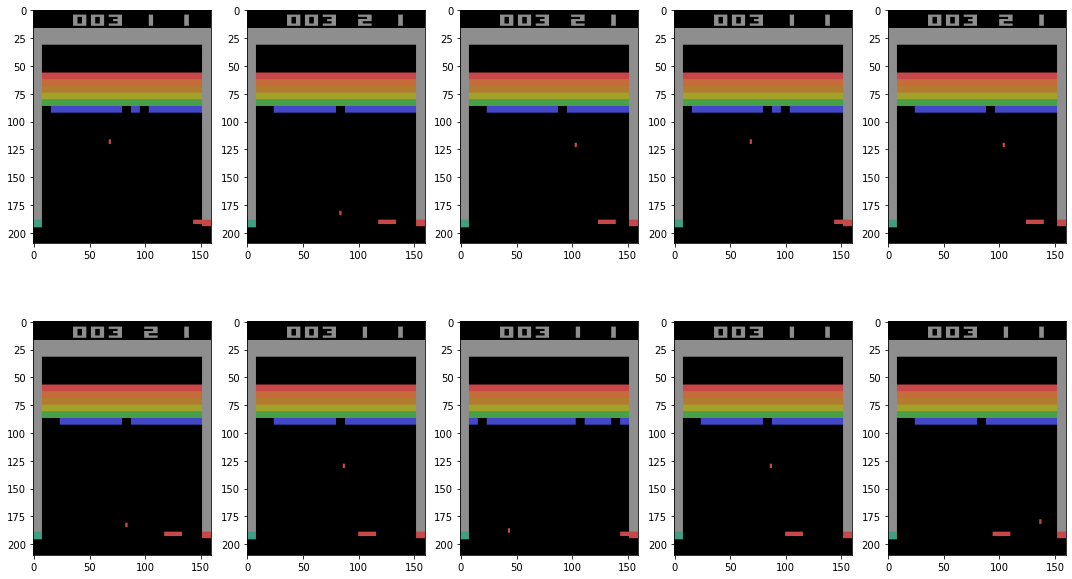

In [88]:
fig, axs = plt.subplots(2, 5)
fig.set_size_inches(18.5, 10.5)
for ax in fig.axes:        
    image = test_buffer.sample(1)[0][0]
    image = image.reshape(210, 160, 3)
    # image = image.permute(2, 0, 1)
    image = image.type(torch.int64)
    ax.imshow(image)